In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import sklearn as skl
from sklearn import kernel_ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def graphfeatures(xtrain, ytrain, xtest, ytest, title):
    fig, ax = plt.subplots(2,6, figsize = (24,12))
    count = 0
    for jj in range(2):
        for ii in range(6):
            if count == 11:
                fig.delaxes(ax[1,5])
                break
            ax[jj][ii].scatter(xtrain[:, count], ytrain, color = 'k')
            ax[jj][ii].scatter(xtest[:, count], ytest, color = 'r')
            ax[jj][ii].set_xlabel('{}'.format(tags[count]), fontsize=20)
            count += 1
    fig.suptitle(title, fontsize = 40)
    return plt.show()

In [3]:
data_train = np.loadtxt('wine_training.csv', delimiter = ',')
data_test = np.loadtxt('wine_test.csv', delimiter = ',')
data_new = np.loadtxt('wine_new_batch.csv', delimiter = ',')
tags = ['Fixed Acidity', 'Volatile Acidity', 'Citric Acid', 'Residual Sugar', 'Chlorides', 'Free Sulfur Dioxide',
        'Total Sulfur Dioxide','Density','pH','Sulphates', 'Alcohol']

X_train = data_train[:,:-1]
Y_train = data_train[:,-1].reshape(-1,1)

X_test = data_test[:,:-1]
Y_test = data_test[:,-1].reshape(-1,1)

In [86]:
X_train_N = X_train.shape[0]
X_train_mean = np.mean(X_train, axis = 0)
X_train_std = np.std(X_train, axis = 0)
X_train_normal = (X_train - np.matlib.repmat(X_train_mean, X_train_N, 1))/np.matlib.repmat(X_train_std, X_train_N, 1)

Y_train_N = Y_train.shape[0]
Y_train_mean = np.mean(Y_train, axis=0)
Y_train_std = np.std(Y_train, axis=0)
Y_train_normal = (Y_train - Y_train_mean)/Y_train_std

X_test_N = X_test.shape[0]
X_test_normal = (X_test - np.matlib.repmat(X_train_mean, X_test_N, 1))/np.matlib.repmat(X_train_std, X_test_N, 1)
Y_test_normal = (Y_test - Y_train_mean)/Y_train_std

X_new_N = data_new.shape[0]
X_new_normal = (data_new - np.matlib.repmat(X_train_mean, X_new_N, 1))/np.matlib.repmat(X_train_std, X_new_N, 1)

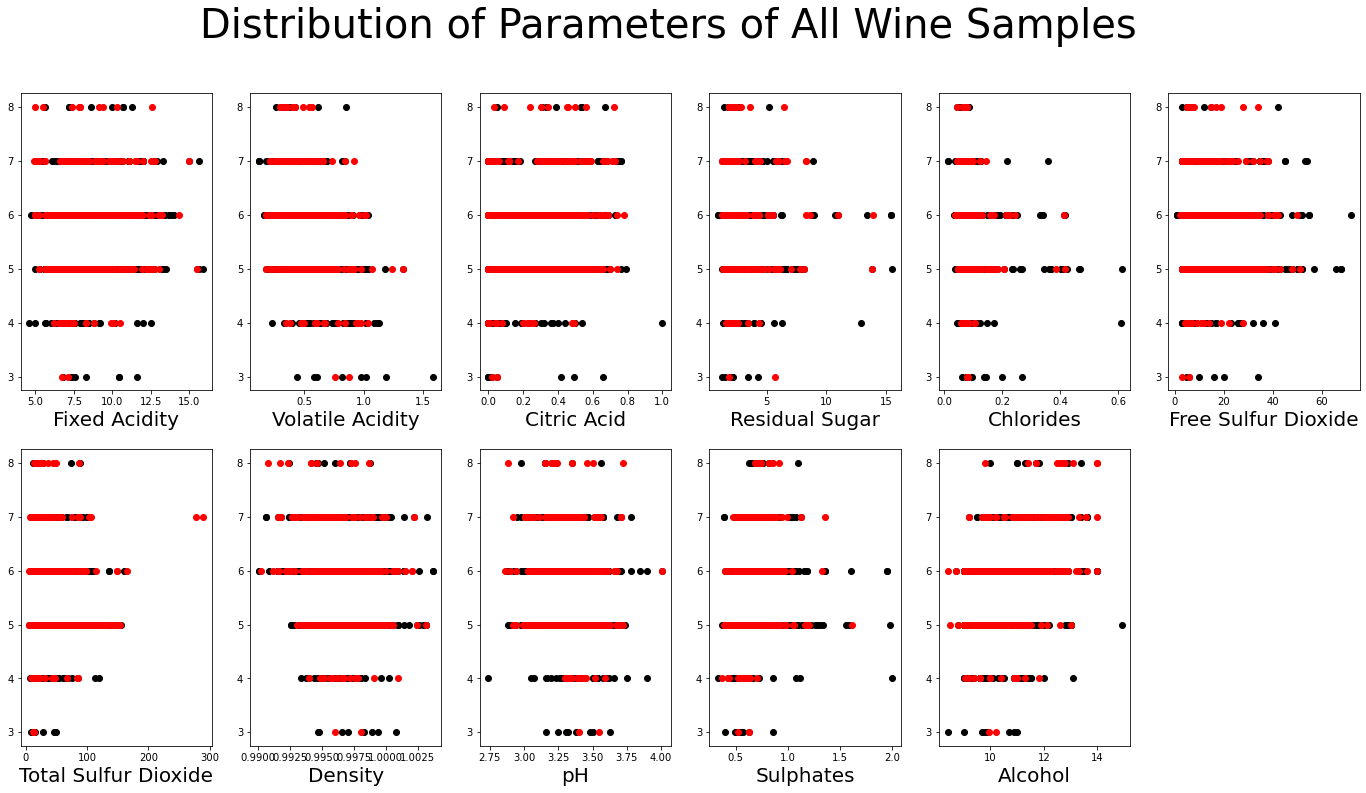

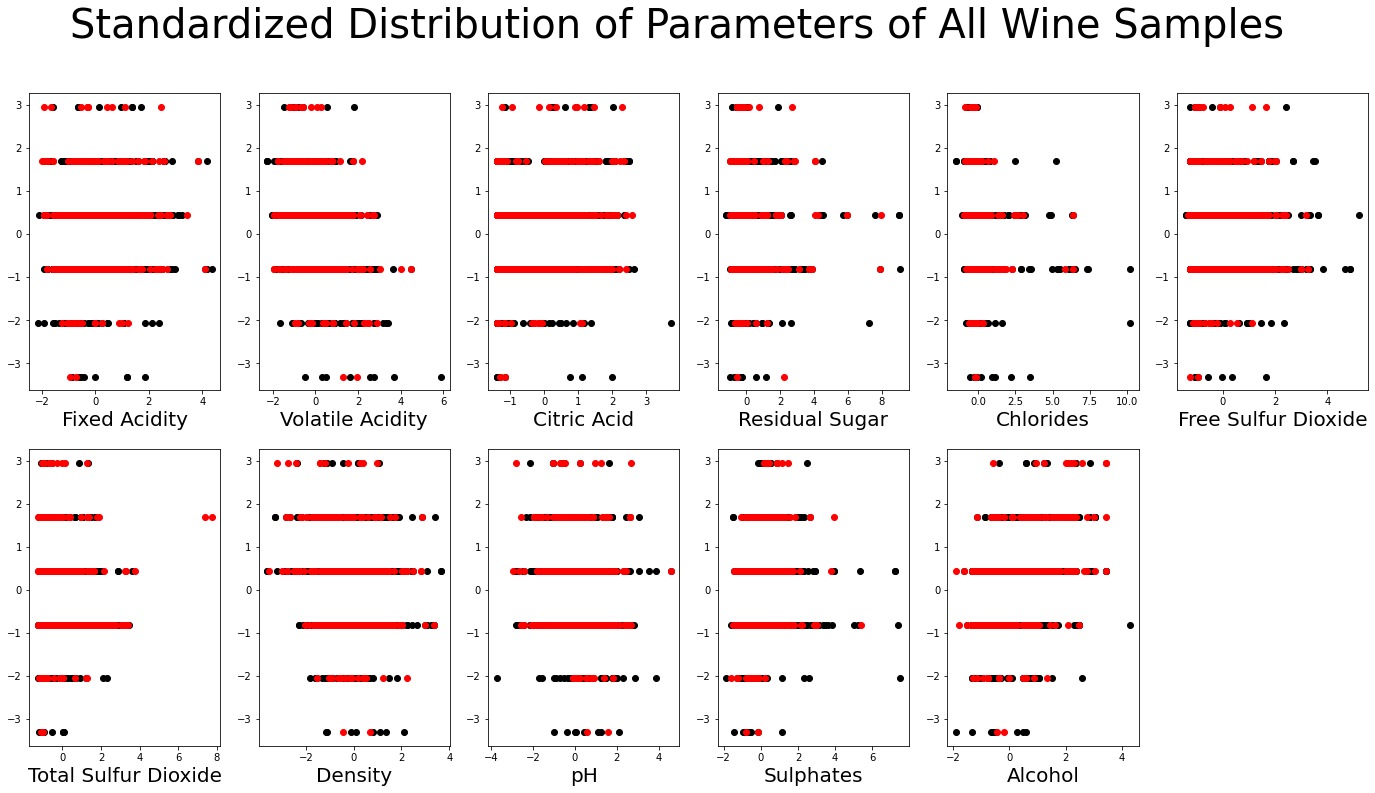

In [6]:
graphfeatures(X_train, Y_train, X_test, Y_test, 'Distribution of Parameters of All Wine Samples')
graphfeatures(X_train_normal, Y_train_normal, X_test_normal, Y_test_normal,
              'Standardized Distribution of Parameters of All Wine Samples')

In [9]:
K_sgm = 10
K_lmbd = 10
sgm = np.linspace(-20, 20, K_sgm)
lmbd = np.linspace(-20, 20, K_lmbd)

scores_rbf = np.zeros((K_sgm, K_lmbd))
scores_std_rbf = np.zeros((K_sgm, K_lmbd))
scores_lap = np.zeros((K_sgm, K_lmbd))
scores_std_lap = np.zeros((K_sgm, K_lmbd))

KRR_CV_rbf = skl.kernel_ridge.KernelRidge(kernel='rbf')
KRR_CV_lap = skl.kernel_ridge.KernelRidge(kernel='laplacian')

for i in range(K_sgm):
    KRR_CV_rbf.gamma = 1/(2*(2**sgm[i])**2)
    for j in range(K_lmbd): 
        KRR_CV_rbf.alpha = (2**lmbd[j])
        this_score_rbf = skl.model_selection.cross_val_score(KRR_CV_rbf, X_train_normal, Y_train_normal, 
                                                         scoring= 'neg_mean_squared_error', cv=10)

        scores_rbf[i,j] = (np.mean(this_score_rbf))
        scores_std_rbf[i,j] = (np.std(this_score_rbf))
        
for i in range(K_sgm):
    KRR_CV_lap.gamma = 1/(2**sgm[i])
    for j in range(K_lmbd): 
        KRR_CV_lap.alpha = (2**lmbd[j])
        this_score_lap = skl.model_selection.cross_val_score(KRR_CV_lap, X_train_normal, Y_train_normal, 
                                                         scoring= 'neg_mean_squared_error', cv=10)

        scores_lap[i,j] = (np.mean(this_score_lap))
        scores_std_lap[i,j] = (np.std(this_score_lap))

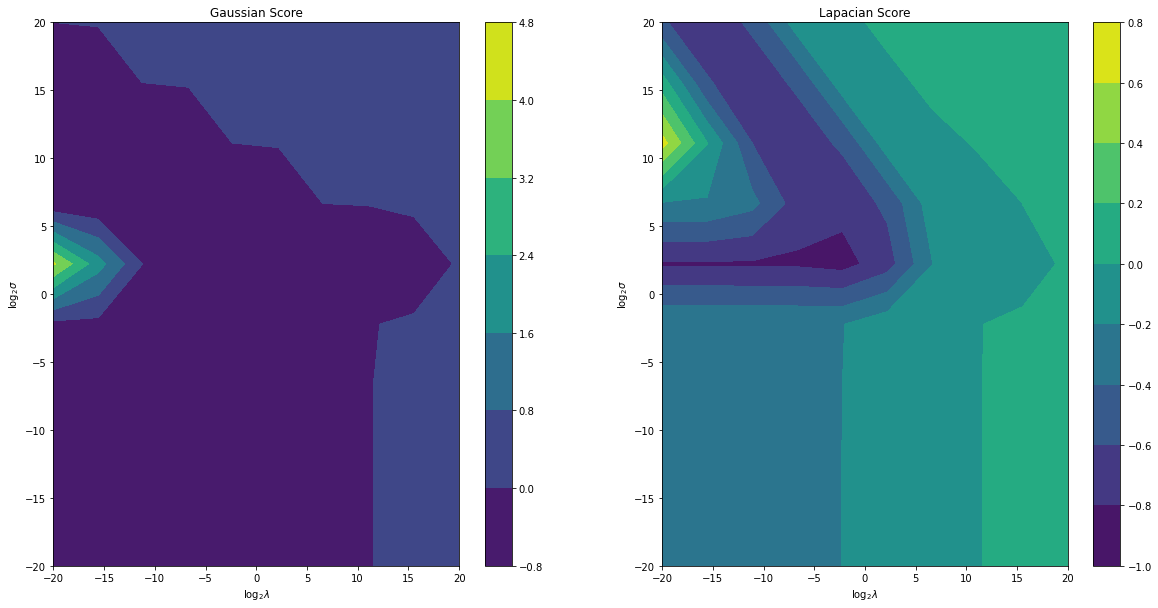

In [10]:
lv, sv = np.meshgrid(lmbd, sgm)

fig, ax = plt.subplots(1,2, figsize=(20,10))

cm0 = ax[0].contourf(lv, sv, np.log2(np.abs(scores_rbf)))
ax[0].set_xlabel('$\log_2\lambda$')
ax[0].set_ylabel('$\log_2\sigma$')
ax[0].set_title('Gaussian Score')
fig.colorbar(cm0, ax=ax[0])

cm0 = ax[1].contourf(lv, sv, np.log2(np.abs(scores_lap)))
ax[1].set_xlabel('$\log_2\lambda$')
ax[1].set_ylabel('$\log_2\sigma$')
ax[1].set_title('Lapacian Score')
fig.colorbar(cm0, ax=ax[1])

plt.show()

In [35]:
ij_max_rbf = np.array(np.where(scores_rbf == scores_rbf.max()), dtype=int).flatten()
ij_max_lap = np.array(np.where(scores_lap == scores_lap.max()), dtype=int).flatten()

sgm_rbf = sgm[ij_max_rbf[0]]
sgm_lap = sgm[ij_max_lap[0]]
lmbd_rbf = lmbd[ij_max_rbf[1]]
lmbd_lap = lmbd[ij_max_lap[1]]

print(sgm_rbf, sgm_lap, lmbd_rbf, lmbd_lap)

2.2222222222222214 2.2222222222222214 -2.2222222222222214 -2.2222222222222214


In [12]:
K_sgm = 20
K_lmbd = 20
sgm_fine = np.linspace(1, 4, K_sgm)
lmbd_fine = np.linspace(-8, -1, K_lmbd)

scores_rbf_fine = np.zeros((K_sgm, K_lmbd))
scores_std_rbf_fine = np.zeros((K_sgm, K_lmbd))
scores_lap_fine = np.zeros((K_sgm, K_lmbd))
scores_std_lap_fine = np.zeros((K_sgm, K_lmbd))

KRR_CV_rbf = skl.kernel_ridge.KernelRidge(kernel='rbf')
KRR_CV_lap = skl.kernel_ridge.KernelRidge(kernel='laplacian')

for i in range(K_sgm):
    KRR_CV_rbf.gamma = 1/(2*(2**sgm_fine[i])**2)
    for j in range(K_lmbd): 
        KRR_CV_rbf.alpha = (2**lmbd_fine[j])
        this_score_rbf_fine = skl.model_selection.cross_val_score(KRR_CV_rbf, X_train_normal, Y_train_normal, 
                                                         scoring= 'neg_mean_squared_error', cv=10)

        scores_rbf_fine[i,j] = (np.mean(this_score_rbf_fine))
        scores_std_rbf_fine[i,j] = (np.std(this_score_rbf_fine))
        
for i in range(K_sgm):
    KRR_CV_lap.gamma = 1/(2**sgm_fine[i])
    for j in range(K_lmbd): 
        KRR_CV_lap.alpha = (2**lmbd_fine[j])
        this_score_lap_fine = skl.model_selection.cross_val_score(KRR_CV_lap, X_train_normal, Y_train_normal, 
                                                         scoring= 'neg_mean_squared_error', cv=10)

        scores_lap_fine[i,j] = (np.mean(this_score_lap_fine))
        scores_std_lap_fine[i,j] = (np.std(this_score_lap_fine))

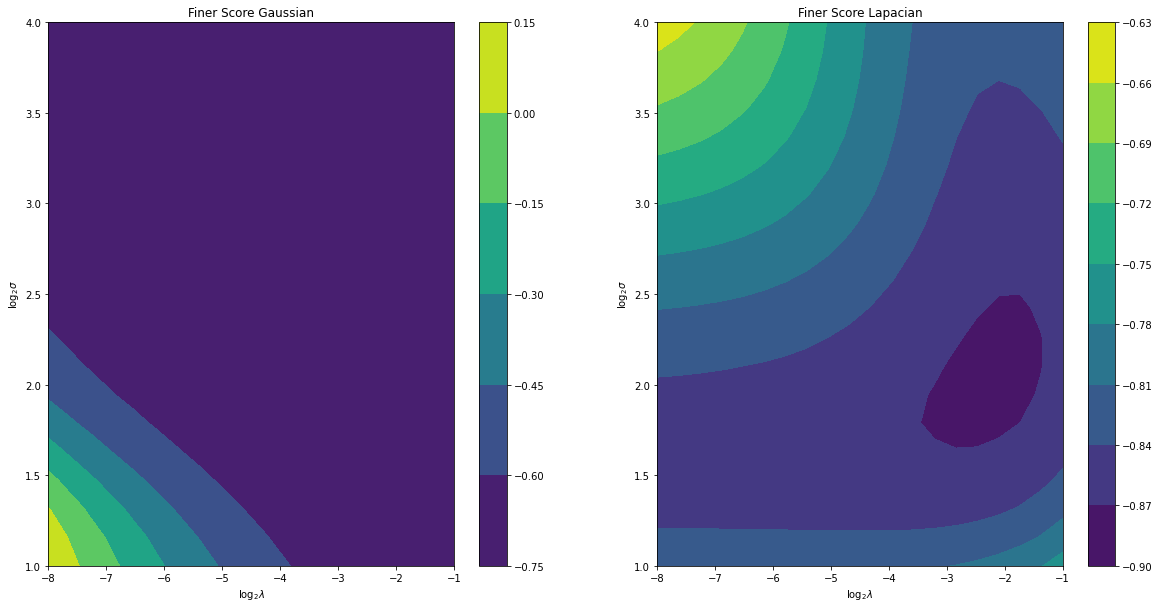

In [13]:
lv, sv = np.meshgrid(lmbd_fine, sgm_fine)

fig, ax = plt.subplots(1,2, figsize=(20,10))

cm0 = ax[0].contourf( lv, sv, np.log2(np.abs(scores_rbf_fine)))
ax[0].set_xlabel('$\log_2\lambda$')
ax[0].set_ylabel('$\log_2\sigma$')
ax[0].set_title('Finer Score Gaussian')
fig.colorbar(cm0, ax=ax[0])

cm0 = ax[1].contourf( lv, sv, np.log2(np.abs(scores_lap_fine)))
ax[1].set_xlabel('$\log_2\lambda$')
ax[1].set_ylabel('$\log_2\sigma$')
ax[1].set_title('Finer Score Lapacian')
fig.colorbar(cm0, ax=ax[1])

plt.show()

In [45]:
ij_max_rbf_fine = np.array(np.where(scores_rbf_fine == scores_rbf_fine.max()), dtype=int).flatten()
ij_max_lap_fine = np.array(np.where(scores_lap_fine == scores_lap_fine.max()), dtype=int).flatten()

sgm_rbf_fine = sgm_fine[ij_max_rbf_fine[0]]
sgm_lap_fine = sgm_fine[ij_max_lap_fine[0]]
lmbd_rbf_fine = lmbd_fine[ij_max_rbf_fine[1]]
lmbd_lap_fine = lmbd_fine[ij_max_lap_fine[1]]
print(sgm_rbf_fine, sgm_lap_fine, lmbd_rbf_fine, lmbd_lap_fine)

1.9473684210526314 2.1052631578947367 -2.473684210526316 -2.105263157894737


In [104]:
KRR_rbf = skl.kernel_ridge.KernelRidge(alpha = 2**lmbd_rbf_fine, kernel='rbf', gamma = 1/(2*(2**sgm_rbf_fine)**2))
KRR_lap = skl.kernel_ridge.KernelRidge(alpha = 2**lmbd_lap_fine, kernel='laplacian', gamma = 1/(2**sgm_lap_fine))

KRR_rbf.fit(X_train_normal, Y_train_normal)
KRR_rbf_train_pred = KRR_rbf.predict(X_train_normal)
KRR_rbf_test_pred = KRR_rbf.predict(X_test_normal)
KRR_rbf_new_pred = KRR_rbf.predict(X_new_normal)

rbf_train_mse = mean_squared_error(Y_train_normal, KRR_rbf_train_pred)
rbf_test_mse = mean_squared_error(Y_test_normal, KRR_rbf_test_pred)

KRR_lap.fit(X_train_normal, Y_train_normal)
KRR_lap_train_pred = KRR_lap.predict(X_train_normal)
KRR_lap_test_pred = KRR_lap.predict(X_test_normal)
KRR_lap_new_pred = KRR_lap.predict(X_new_normal)

lap_train_mse = mean_squared_error(Y_train_normal, KRR_lap_train_pred)
lap_test_mse = mean_squared_error(Y_test_normal, KRR_lap_test_pred)

print(rbf_train_mse, rbf_test_mse, lap_train_mse, lap_test_mse)

0.45889231096869 0.6814724227982332 0.05788516815435243 0.6076617940256125


In [105]:
linreg = LinearRegression().fit(X_train_normal,Y_train_normal)
linreg_train_pred = linreg.predict(X_train_normal)
linreg_test_pred = linreg.predict(X_test_normal)
linreg_new_pred = linreg.predict(X_new_normal)

linreg_train_mse = mean_squared_error(Y_train_normal, linreg_train_pred)
linreg_test_mse = mean_squared_error(Y_test_normal, linreg_test_pred)
print(linreg_train_mse, linreg_test_mse)

0.6278484956554882 0.747169690518721


In [106]:
rbf_new_score = (KRR_rbf_new_pred * Y_train_std) + Y_train_mean
lap_new_score = (KRR_lap_new_pred * Y_train_std) + Y_train_mean
linreg_new_score = (linreg_new_pred * Y_train_std) + Y_train_mean

round_rbf_new = np.round(rbf_new_score)
round_lap_new = np.round(lap_new_score)
round_lin_new = np.round(linreg_new_score)

In [107]:
noround_new_scores = np.concatenate((linreg_new_score, rbf_new_score, lap_new_score),axis = 1)
new_scores = np.concatenate((round_lin_new, round_rbf_new, round_lap_new),axis = 1)
print(new_scores)
print(noround_new_scores)

[[6. 6. 6.]
 [5. 5. 5.]
 [6. 5. 6.]
 [6. 6. 6.]
 [6. 6. 6.]]
[[6.00469789 5.98570469 6.04718504]
 [5.28767761 5.43500991 5.4749348 ]
 [5.56363072 5.34827857 5.623982  ]
 [6.067022   6.12354724 5.97322514]
 [5.94248207 6.0470551  6.00728097]]
